In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR
from torch import autograd
from torch.autograd import Variable
from tensorboardX import SummaryWriter

from typing import Dict, Tuple
from tqdm import tqdm
import numpy as np
import time
import os
import random
from tabulate import tabulate

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

%matplotlib inline

if __name__ == "__main__":
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else "No GPU detected")



Torch version: 2.7.0+cu126
CUDA available: True
CUDA version: 12.6
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 4090


### Loading in Dataset

In [2]:
from waveguide_dataset import WaveguideDataset
dataset = WaveguideDataset('train_test_split.h5')

# # Define split sizes (e.g., 80% train, 20% test)
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size

# # Split the dataset
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# # Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
# test_loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=4)
# pbar = tqdm(test_loader)
# i=0
# for c, p, x in pbar:
#     print(c)
#     break


### CNN Modules

In [3]:
class Flatten(nn.Module):
    """
    Flatten function so can include in nn.Sequential(...)
    """
    def forward(self, x):
        return torch.flatten(x, 1)  # flatten all dimensions except batch

class Net(nn.Module):
    """
    Does CNN on input waveguide, concatenates with conditional parameters, then
    does fully connected nn to output final tensor of values
    """
    def __init__(self):
        super(Net, self).__init__()
        
        # CNN feature extractor for the image
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),  # [B, 1, 32, 32] -> [B, 32, 30, 30]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),  # -> [B, 64, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2),          # -> [B, 64, 14, 14]
            nn.Dropout(0.25),
            Flatten()                 # -> [B, 64*14*14 = 12544]
        )

        # Fully connected layers after combining with 4-dim condition
        self.fc = nn.Sequential(
            nn.Linear(12544 + 4, 128),  # Concatenate condition
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 8)           # Output 8 continuous values
        )

    def forward(self, x_img, x_cond):
        x = self.cnn(x_img)                 # [B, 12544]
        x = torch.cat((x, x_cond), dim=1)   # [B, 12544 + 4]
        output = self.fc(x)                 # [B, 8]
        return output

In [4]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class Flatten(nn.Module):
#     def forward(self, x):
#         return x.view(x.size(0), -1)

class Net2(nn.Module):
    """
    CNN processes input waveguide image.
    Output is concatenated with 4D conditional input, then passed through fully connected layers.
    Output is 8 continuous values.
    """
    def __init__(self):
        super(Net2, self).__init__()
        
        # Convolutional layers with BatchNorm and deeper capacity
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # -> [B, 32, 32, 32]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # -> [B, 64, 32, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                                        # -> [B, 64, 16, 16]
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # -> [B, 128, 16, 16]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                                        # -> [B, 128, 8, 8]
            nn.Dropout(0.25),

            Flatten()                                               # -> [B, 128*8*8 = 8192]
        )

        # Fully connected layers after conditioning
        self.fc = nn.Sequential(
            nn.Linear(8192 + 4, 512),  # Concatenate image features and 4-dim condition
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(128, 8)  # Output layer
        )

    def forward(self, x_img, x_cond):
        x = self.cnn(x_img)                 # [B, 8192]
        x = torch.cat((x, x_cond), dim=1)   # [B, 8196]
        output = self.fc(x)                 # [B, 8]
        return output


In [5]:
class Net3(nn.Module):
    """
    Wider CNN + FC architecture for regression on waveguide input with conditional features.
    """
    def __init__(self):
        super(Net3, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),   # [B, 64, 32, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # [B, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                                        # [B, 128, 16, 16]
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# [B, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),                                        # [B, 256, 8, 8]
            nn.Dropout(0.25),

            Flatten()                                               # [B, 256*8*8 = 16384]
        )

        self.fc = nn.Sequential(
            nn.Linear(16384 + 4, 1024),  # [B, 16388]
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 8)  # Output
        )

    def forward(self, x_img, x_cond):
        x = self.cnn(x_img)                 # [B, 16384]
        x = torch.cat((x, x_cond), dim=1)   # [B, 16388]
        return self.fc(x)


In [6]:
def train(model, device, train_loader_in, optimizer, loss_fn):
    model.train()
    i = 0
    train_loader = tqdm(train_loader_in)
    for target, p, x in train_loader:
        i += 1
        target, p, x = target.to(device), p.to(device), x.to(device)
        optimizer.zero_grad()
        output = model(x, p)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loader.set_description(f"loss: {loss.item():.4f}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1)
# pbar = tqdm(dataloader)
# train(model, device, pbar, optimizer)


In [7]:
# def test(model, device, test_loader_in, loss_fn, dataset):
#     model.eval()
#     test_loss = 0
#     samples = []
#     test_loader = tqdm(test_loader_in)
#     with torch.no_grad():
#         for target, p, x in test_loader:
#             target, p, x = target.to(device), p.to(device), x.to(device)
#             output = model(x,p)
#             test_loss += loss_fn(output, target).item() * x.size(0)
#             for t, o in zip(target.cpu(), output.cpu()):
#                 t_unnorm = dataset.denormalize_cond(t)
#                 o_unnorm = dataset.denormalize_cond(o)
#                 if len(samples) < 50:
#                     samples.append((t_unnorm.numpy(), o_unnorm.numpy()))

#     test_loss /= len(test_loader_in.dataset)
#     print(f'\nTest set: Average loss: {test_loss:.4f}\n')

#     chosen = random.sample(samples, 8)
#     index = []
#     targets = []
#     outputs = []
#     for i, (target, output) in enumerate(chosen):
#         index.append(i)
#         targets.append([f"{v:.3f}" for v in target.tolist()])
#         outputs.append([f"{v:.3f}" for v in output.tolist()])
    
#     headers = [' '] + index
#     row_1 = ['Target'] + targets
#     row_2 = ['Output'] + outputs
#     print(tabulate([row_1, row_2], headers=headers, tablefmt='orgtbl'))
def test(model, device, test_loader, loss_fn, dataset):
    model.eval()
    test_loss = 0
    correct = 0
    samples = []

    with torch.no_grad():
        for target, p, x in tqdm(test_loader):
            target, p, x = target.to(device), p.to(device), x.to(device)
            output = model(x, p)
            test_loss += loss_fn(output, target).item() * x.size(0)
            for t, o, params in zip(target.cpu(), output.cpu(), p.cpu()):
                t_real = dataset.denormalize_cond(t)
                o_real = dataset.denormalize_cond(o)
                # params_real = dataset.denormalize_param(params)
                if len(samples) < 50:
                    samples.append((t_real.numpy(), o_real.numpy(), params.numpy()))#, params_real.numpy()))

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}\n')

    chosen = random.sample(samples, 8)

    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    axs = axs.flatten()

    for i, (target, output, param) in enumerate(chosen):
        axs[i].plot(range(4), target[:4], 'r-o', label='Target')
        axs[i].plot(range(4), output[:4], 'b--o', label='Output')
        axs[i].set_title(f"Params: {param.round(2)}")
        axs[i].set_xlabel("Mode #")
        axs[i].set_ylabel("Value")
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()
    return test_loss
    

Epoch #0:


100%|██████████| 220/220 [00:26<00:00,  8.37it/s]



Test set: Average loss: 0.2037



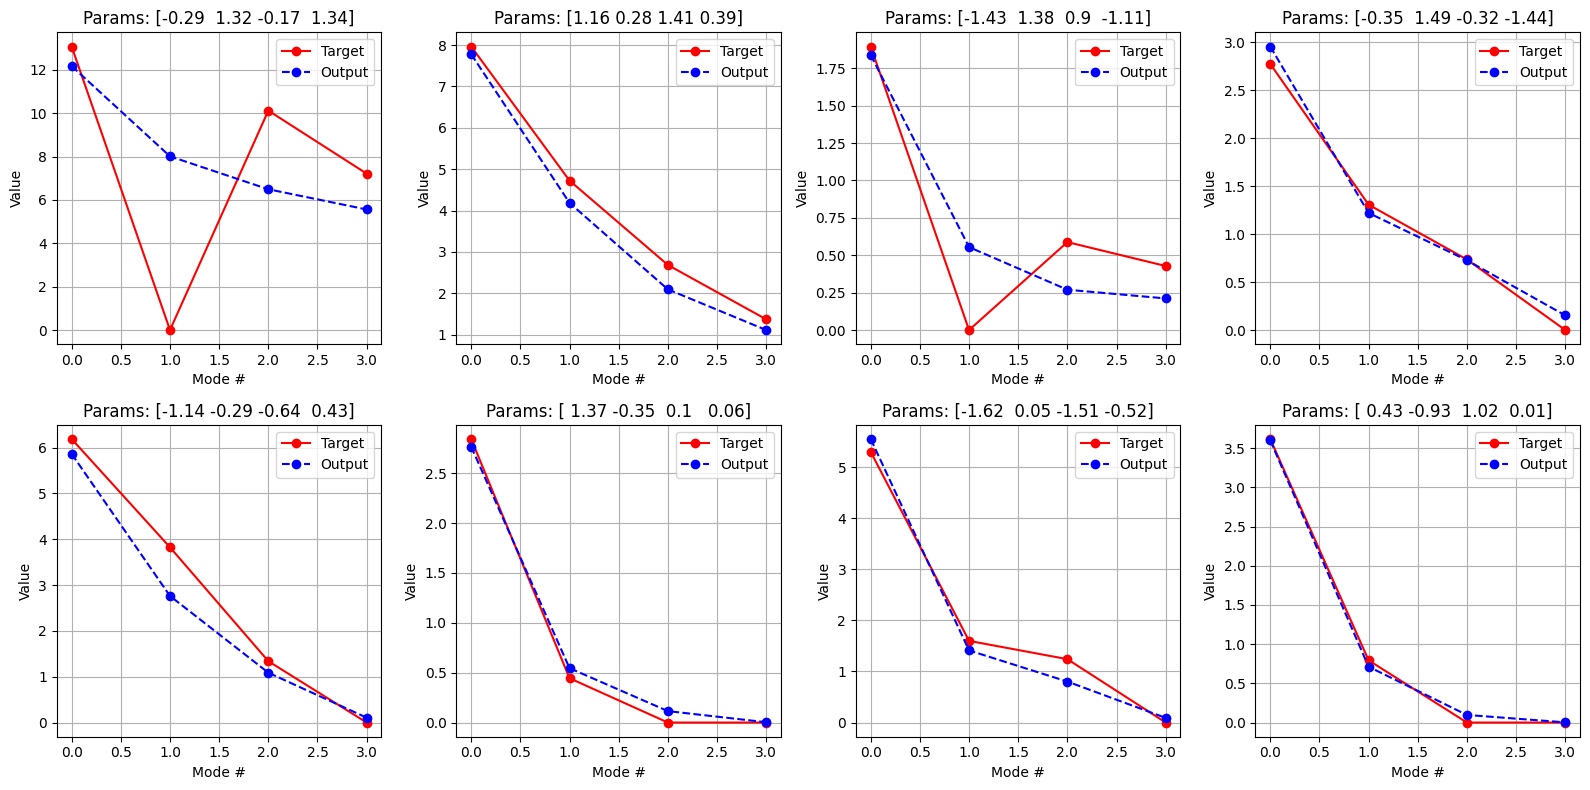

Epoch #1:


100%|██████████| 220/220 [00:25<00:00,  8.73it/s]



Test set: Average loss: 0.1825



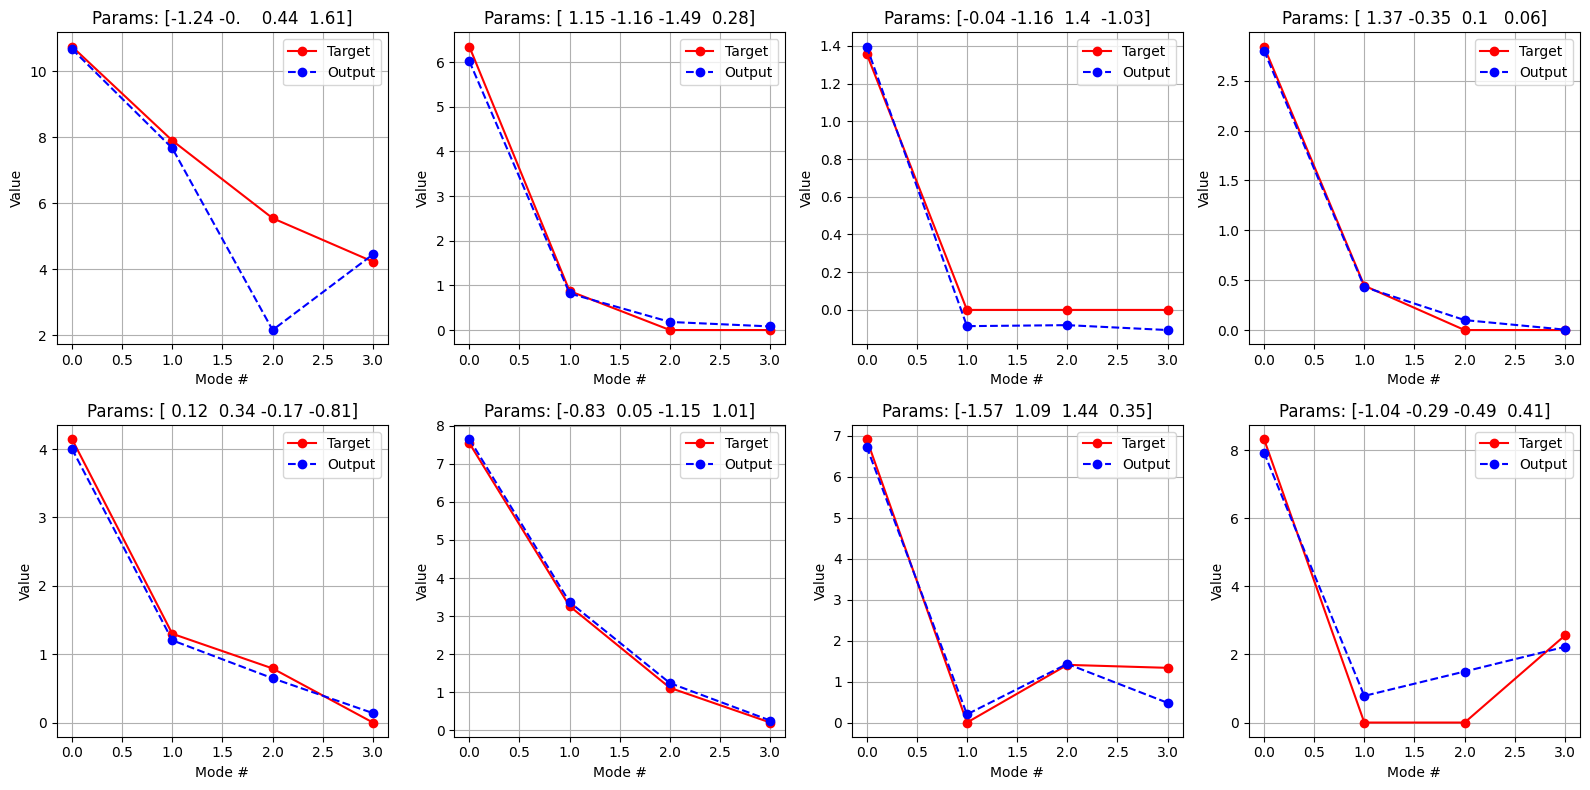

Epoch #2:


100%|██████████| 220/220 [00:25<00:00,  8.63it/s]



Test set: Average loss: 0.1996



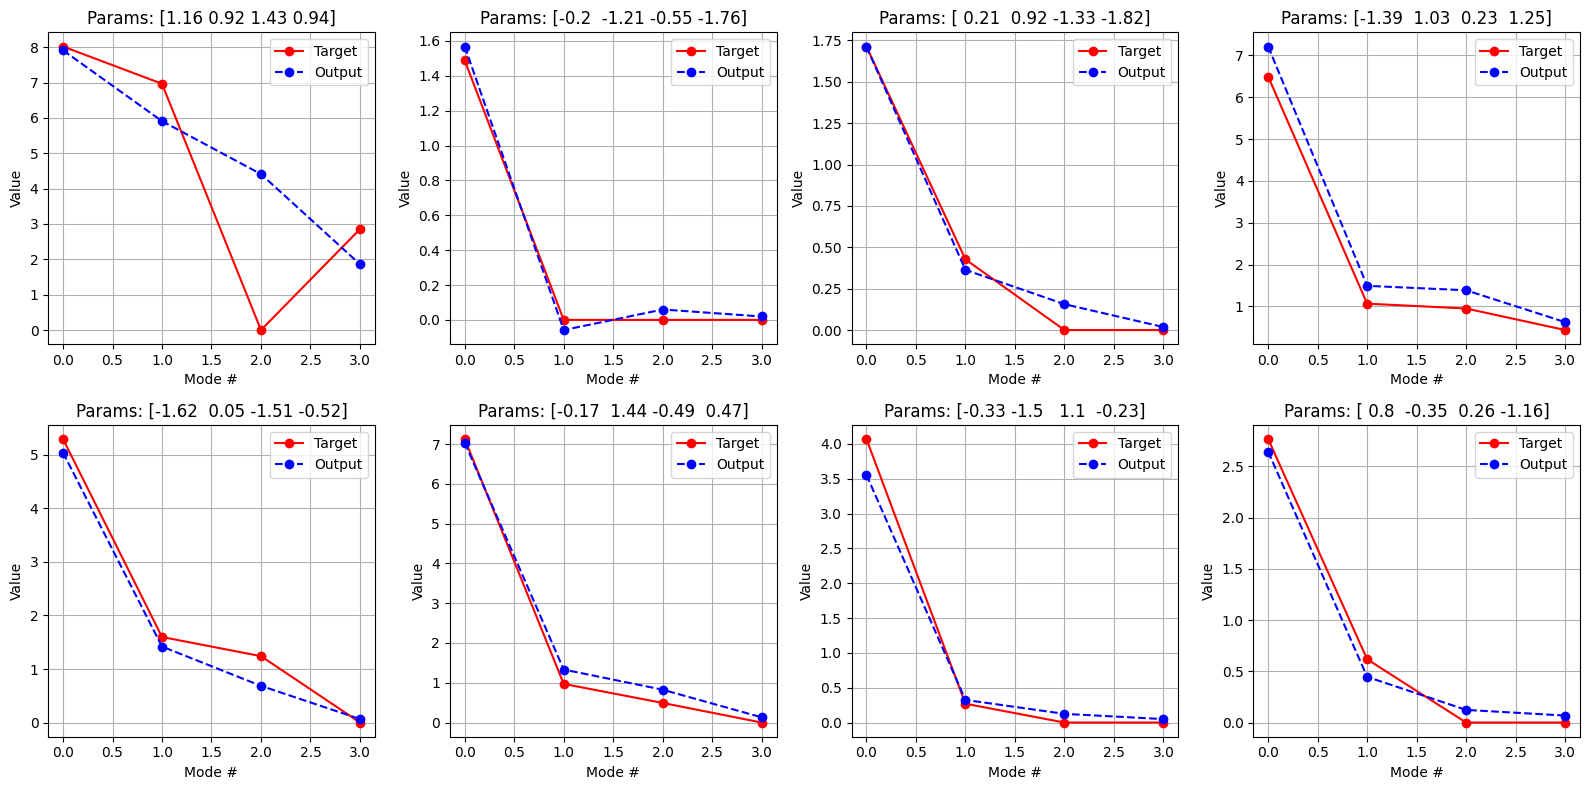

Epoch #3:


100%|██████████| 220/220 [00:25<00:00,  8.65it/s]



Test set: Average loss: 0.1865



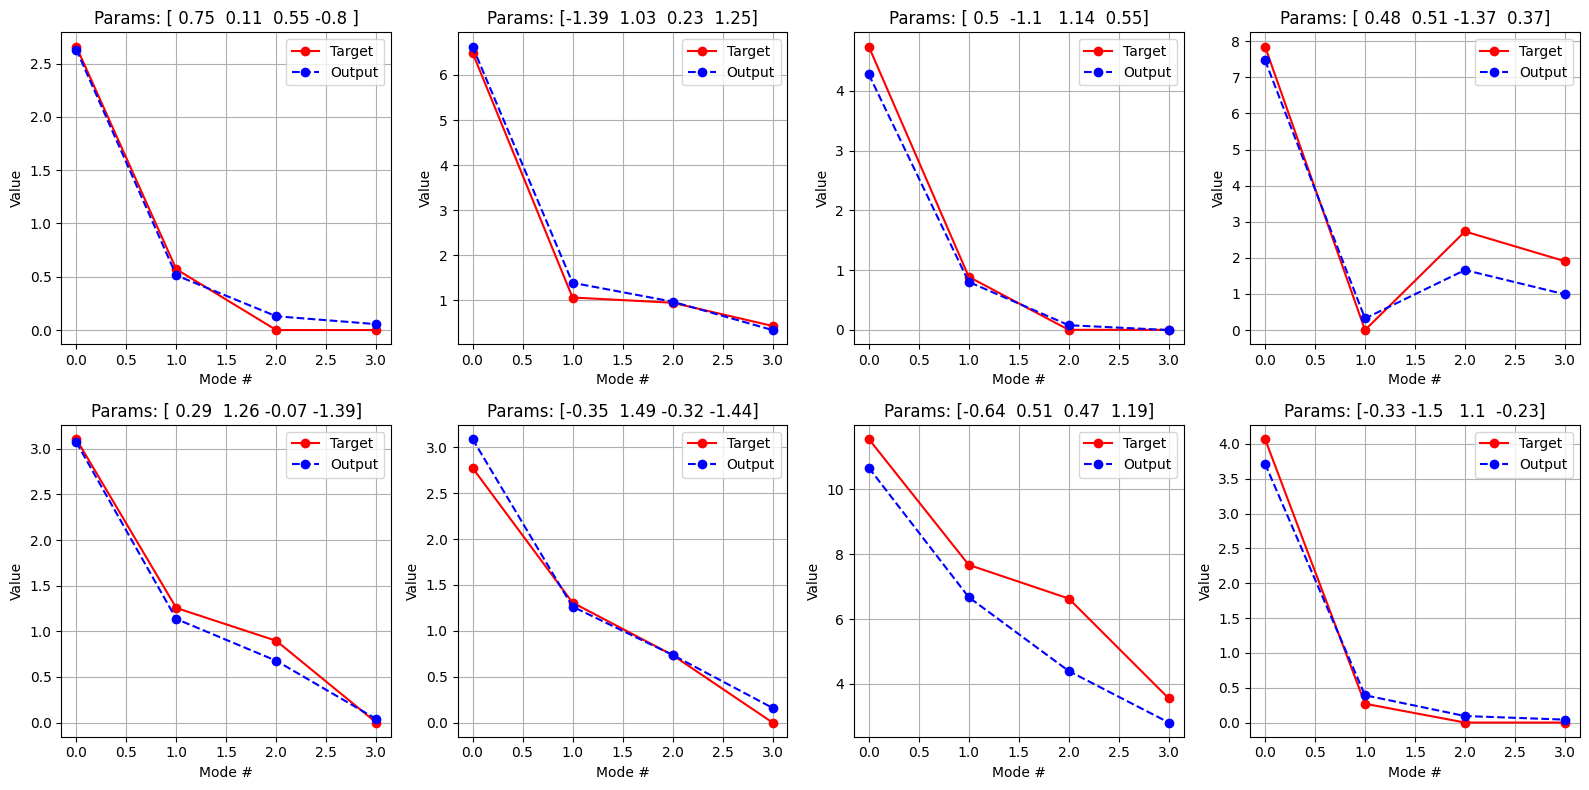

Epoch #4:


100%|██████████| 220/220 [00:25<00:00,  8.73it/s]



Test set: Average loss: 0.1646



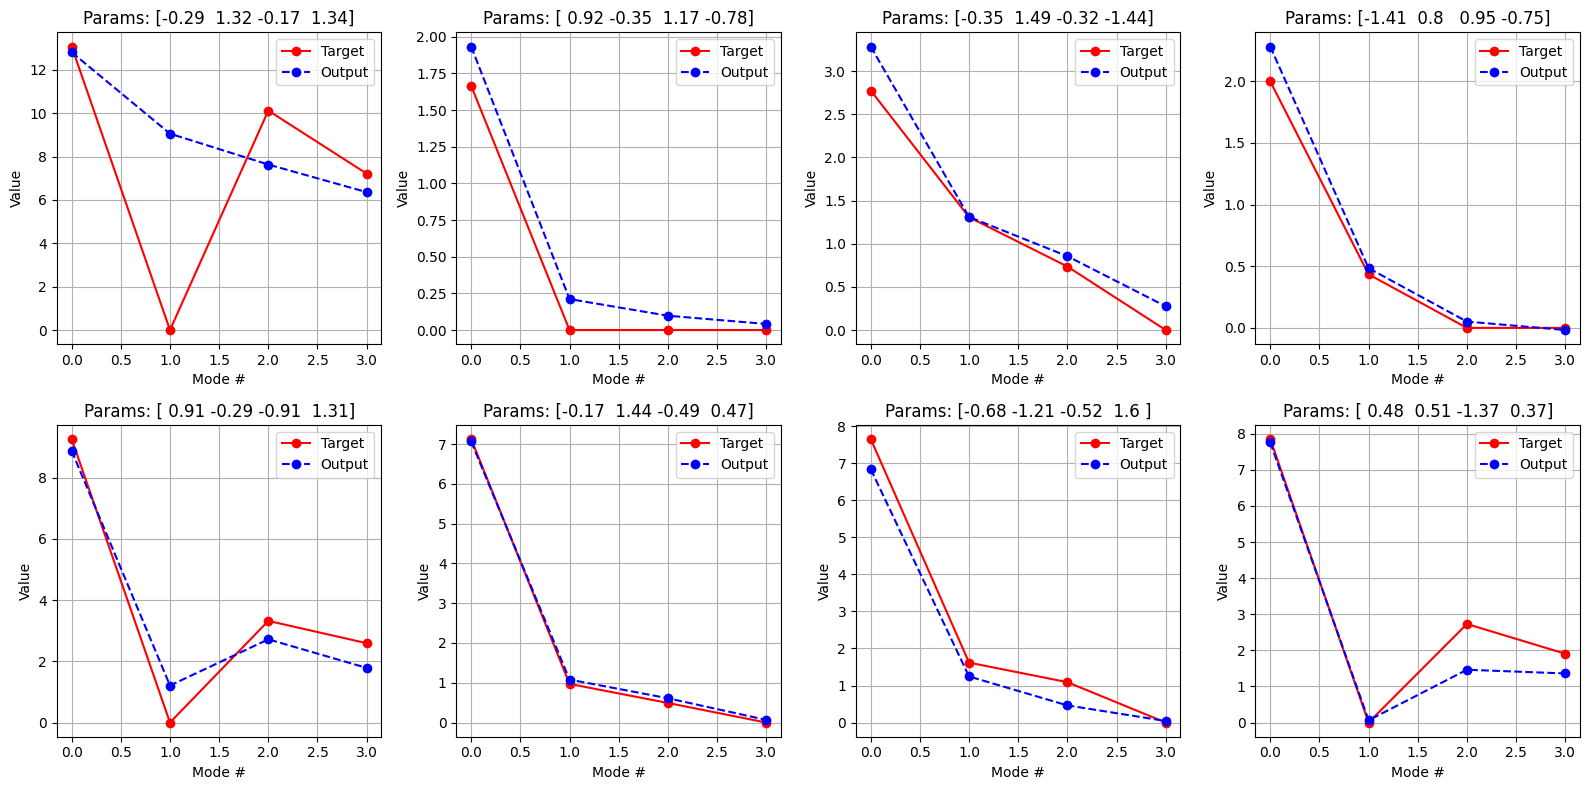

Epoch #5:


100%|██████████| 220/220 [00:25<00:00,  8.72it/s]



Test set: Average loss: 0.1695



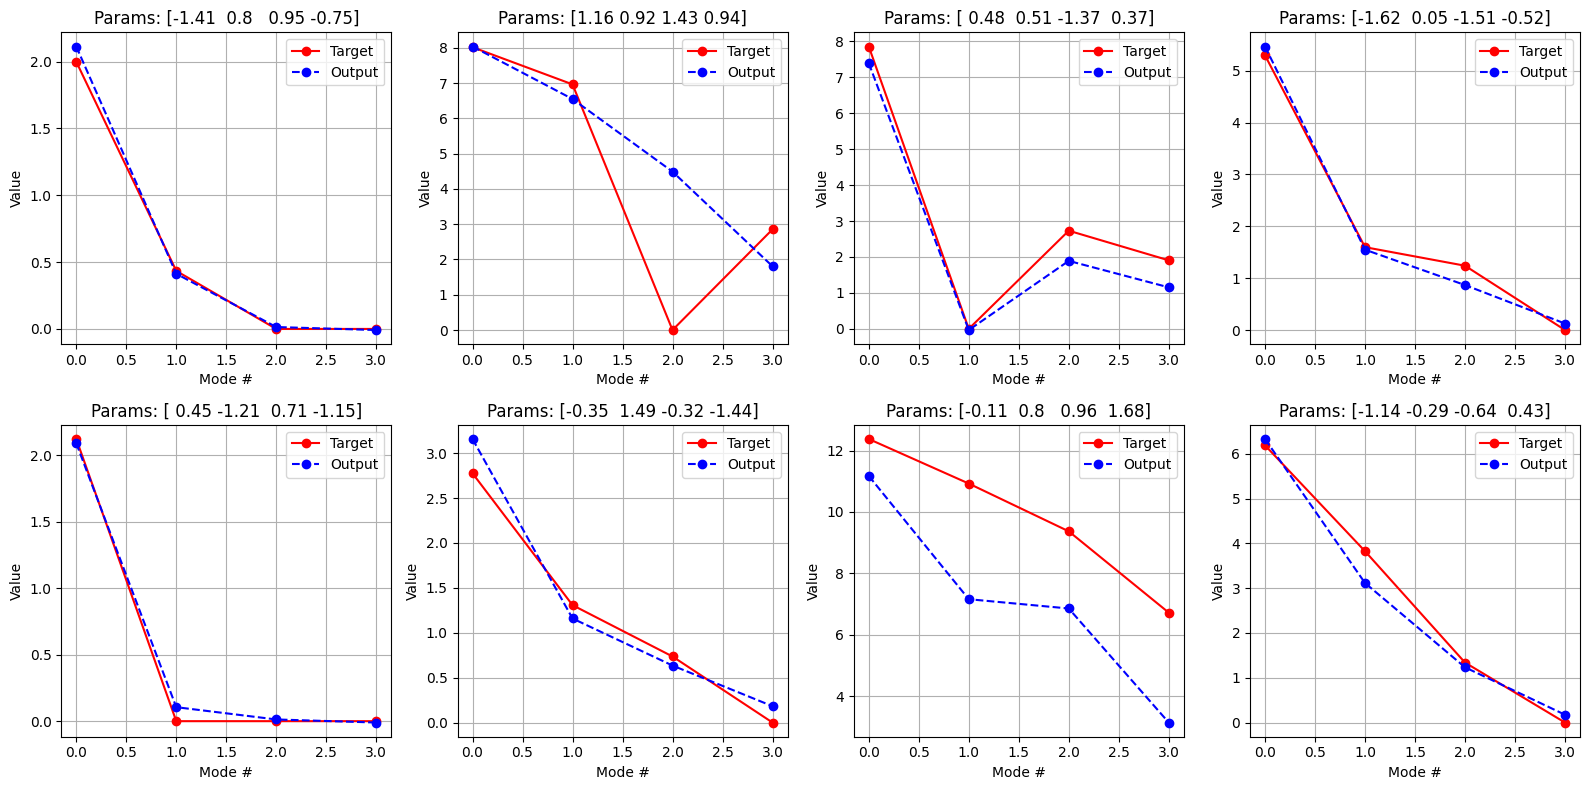

Epoch #6:


100%|██████████| 220/220 [00:25<00:00,  8.49it/s]



Test set: Average loss: 0.1764



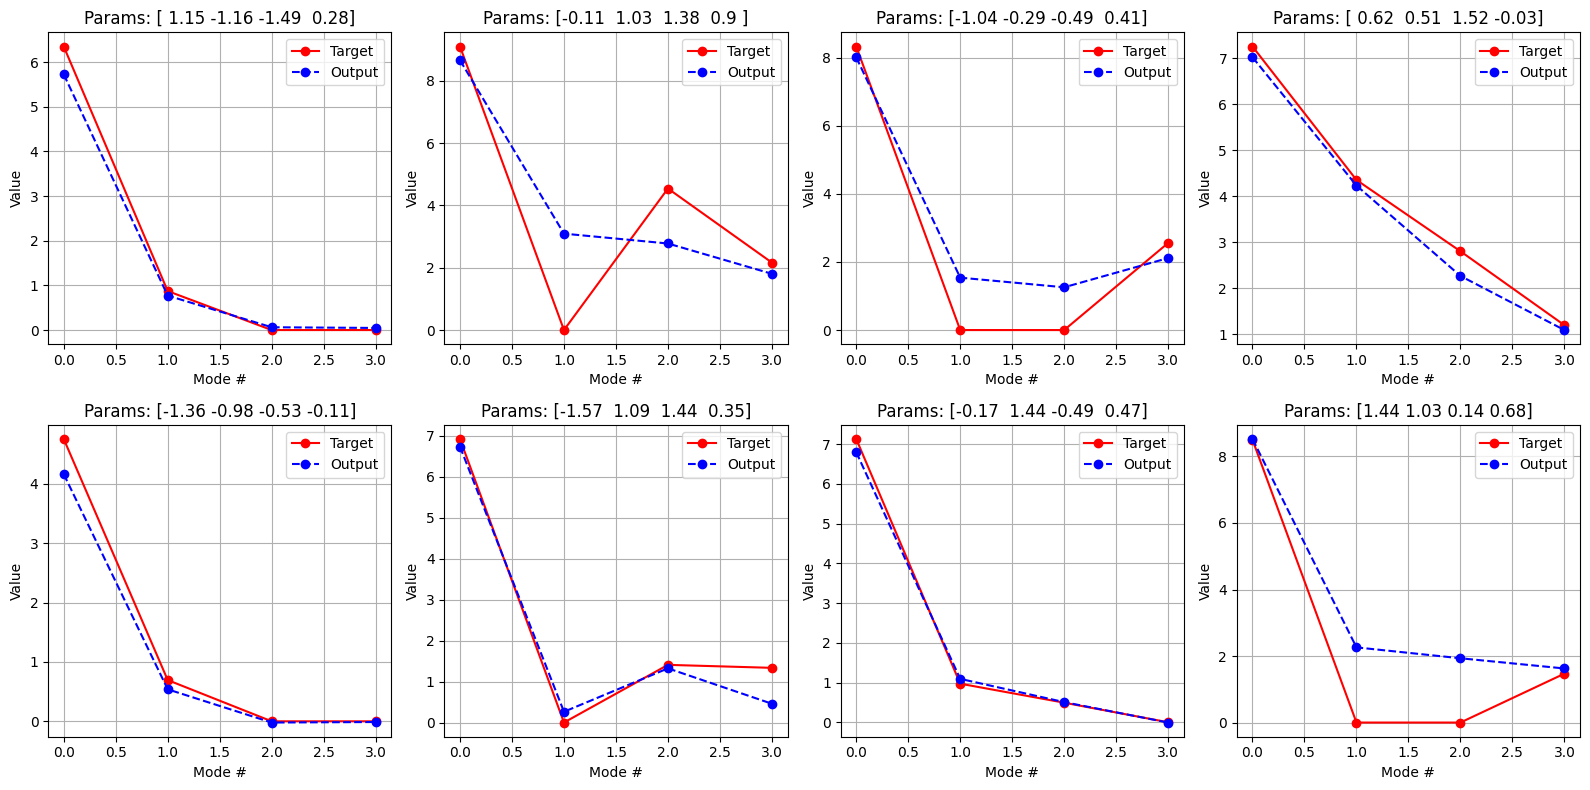

Epoch #7:


100%|██████████| 220/220 [00:24<00:00,  8.89it/s]



Test set: Average loss: 0.1816



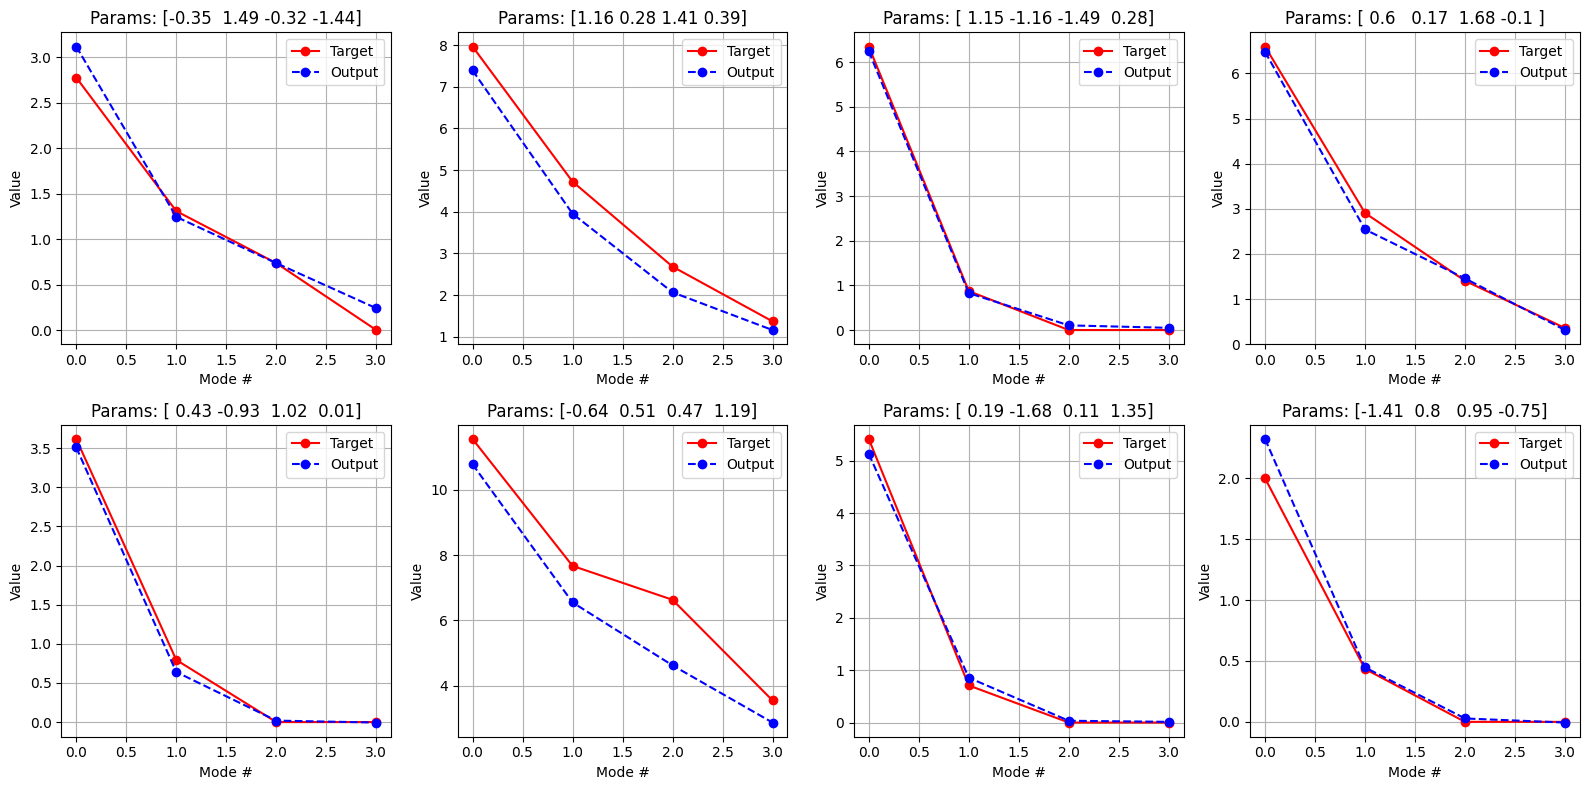

Epoch #8:


100%|██████████| 220/220 [00:24<00:00,  8.83it/s]



Test set: Average loss: 0.1598



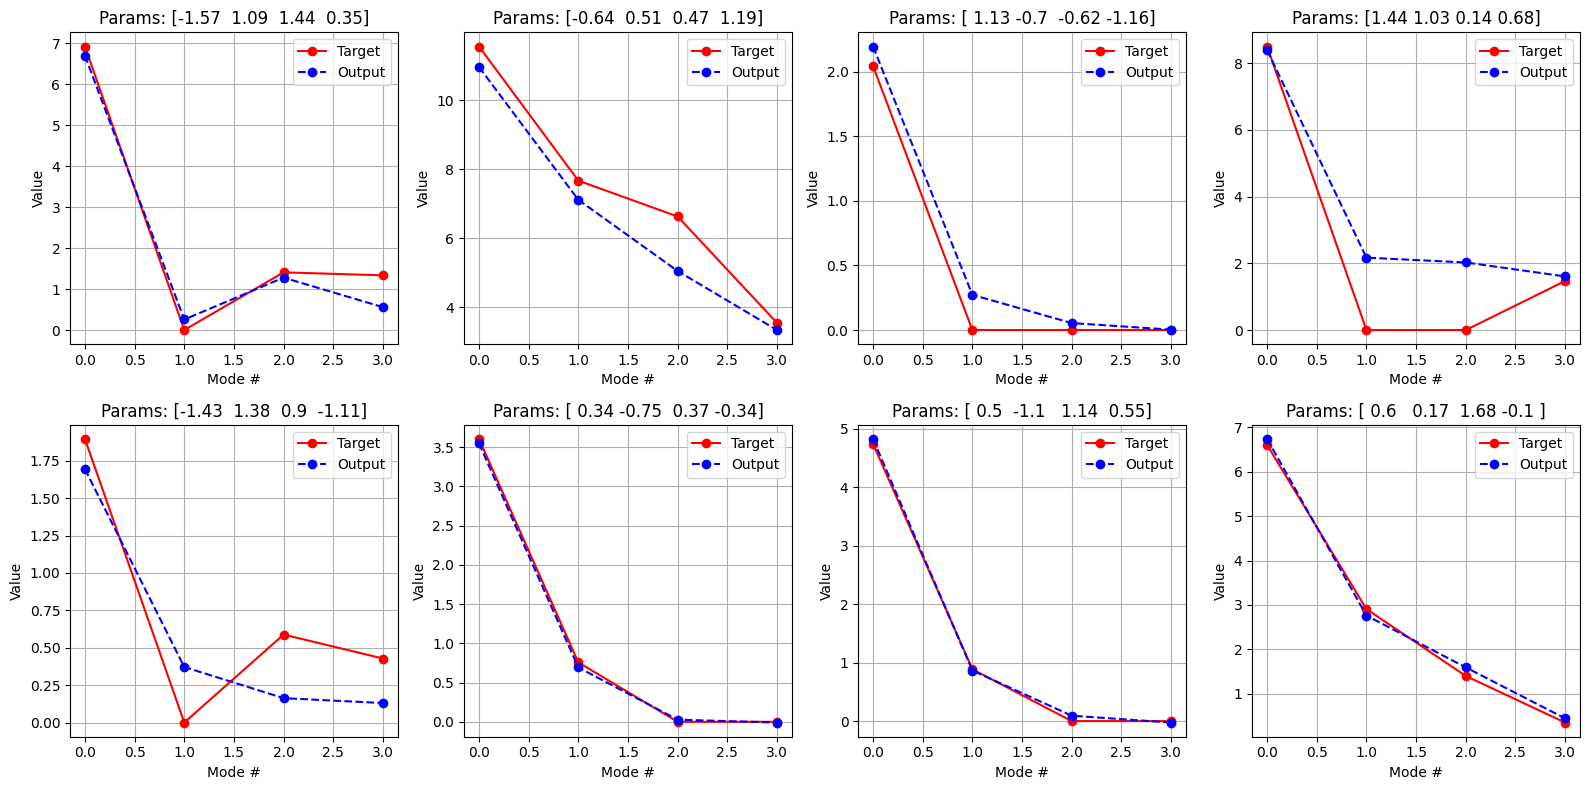

Epoch #9:


100%|██████████| 220/220 [00:25<00:00,  8.61it/s]



Test set: Average loss: 0.1589



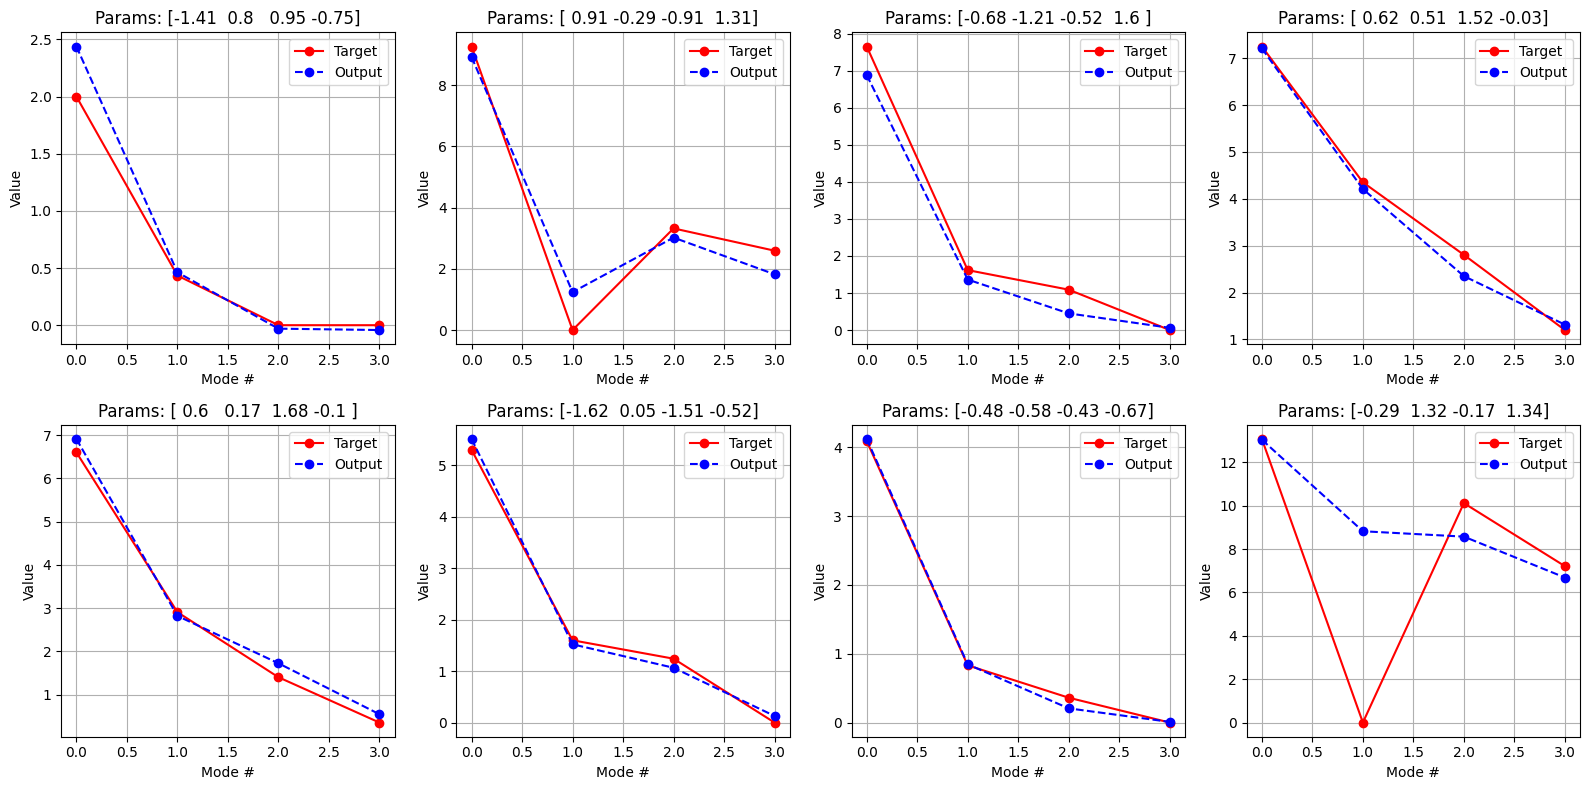

Epoch #10:


100%|██████████| 220/220 [00:24<00:00,  8.95it/s]



Test set: Average loss: 0.1575



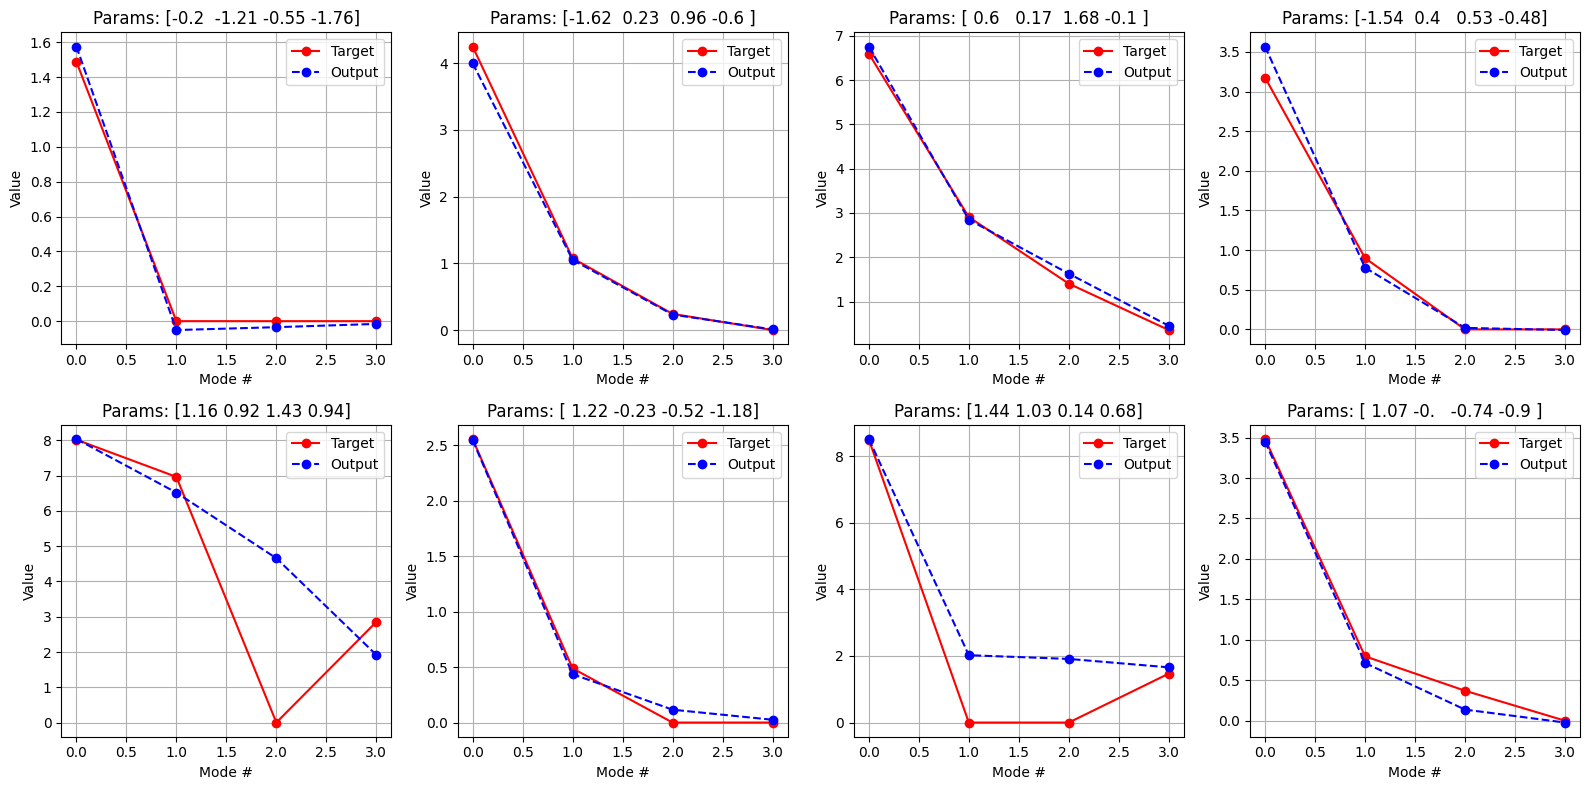

Epoch #11:


100%|██████████| 220/220 [00:24<00:00,  8.83it/s]



Test set: Average loss: 0.1620



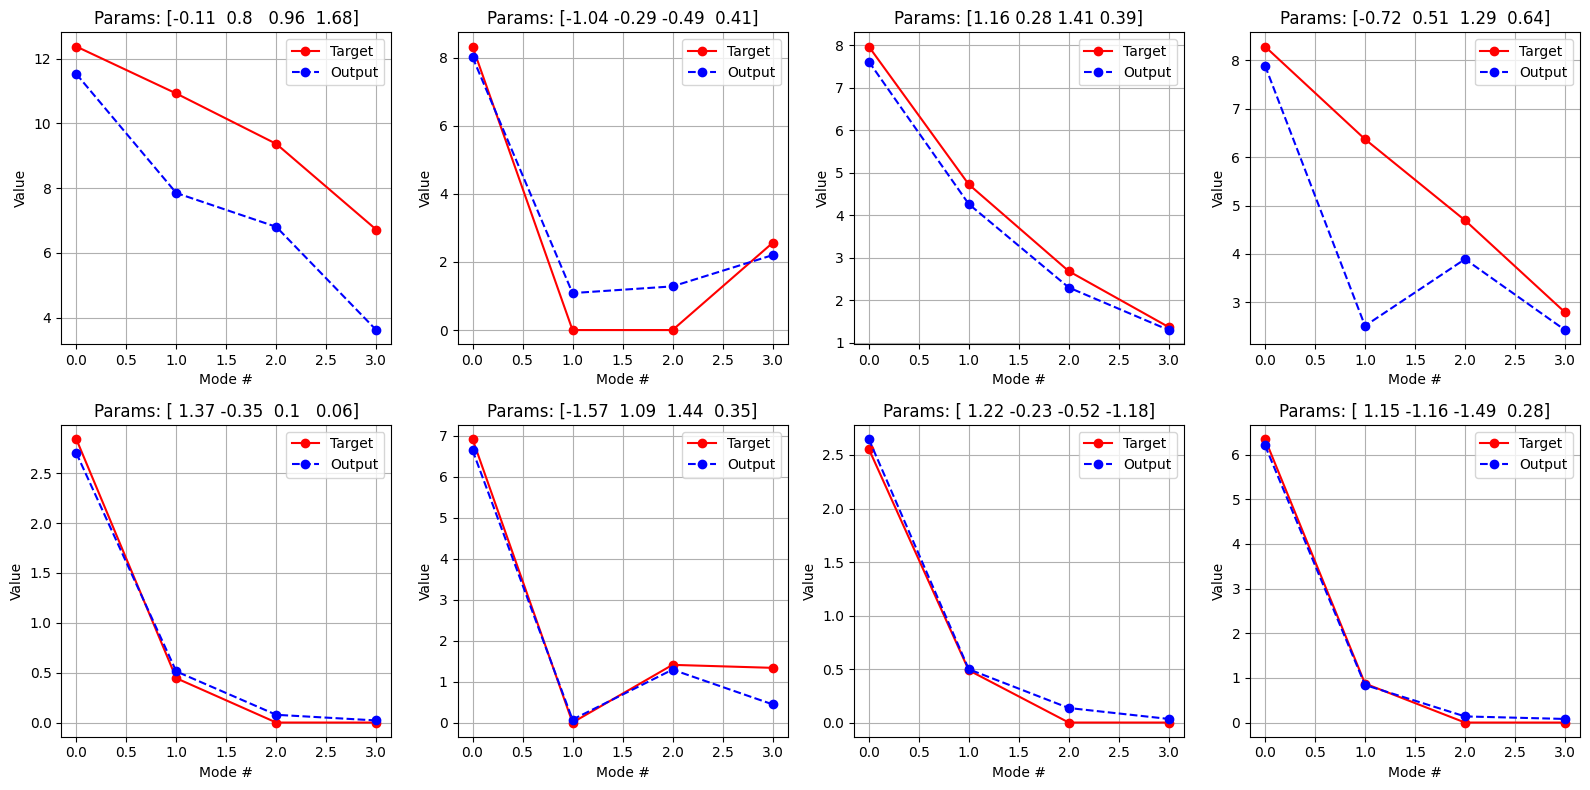

Epoch #12:


100%|██████████| 220/220 [00:28<00:00,  7.77it/s]



Test set: Average loss: 0.1576



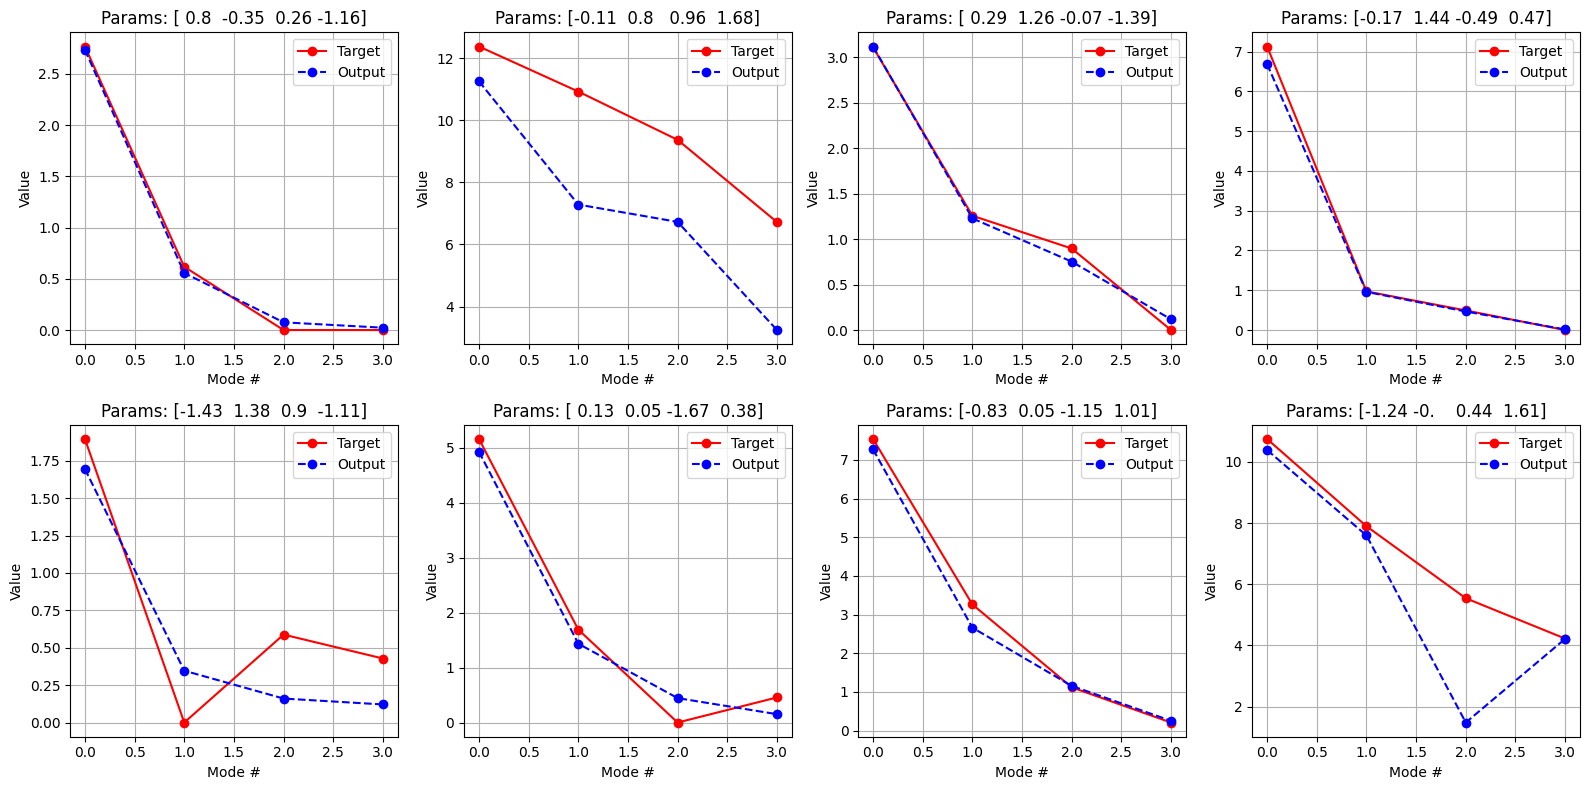

Epoch #13:


100%|██████████| 220/220 [00:26<00:00,  8.20it/s]



Test set: Average loss: 0.1546



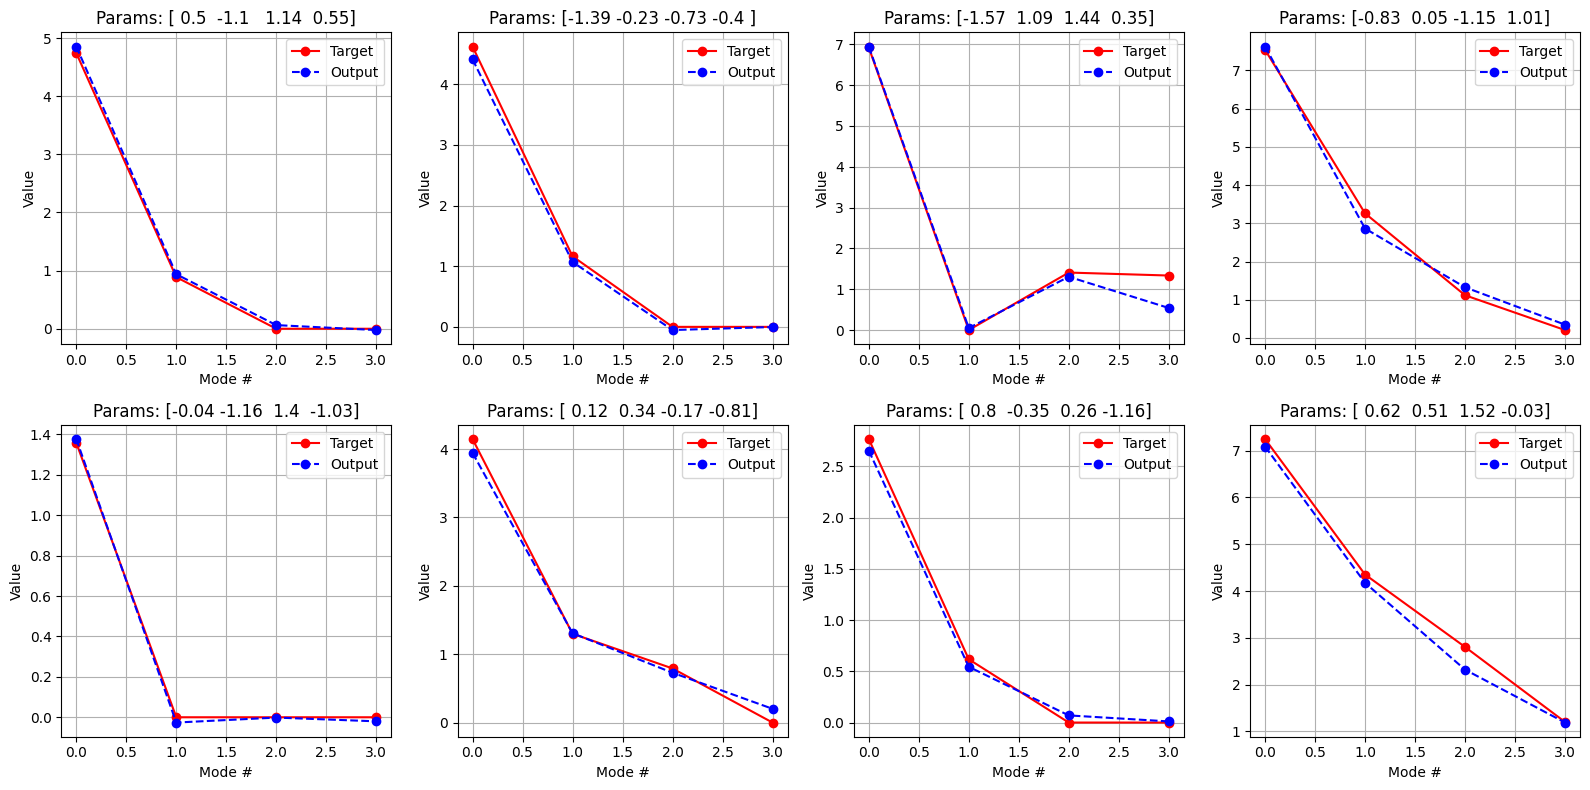

Epoch #14:


100%|██████████| 220/220 [00:25<00:00,  8.65it/s]



Test set: Average loss: 0.1529



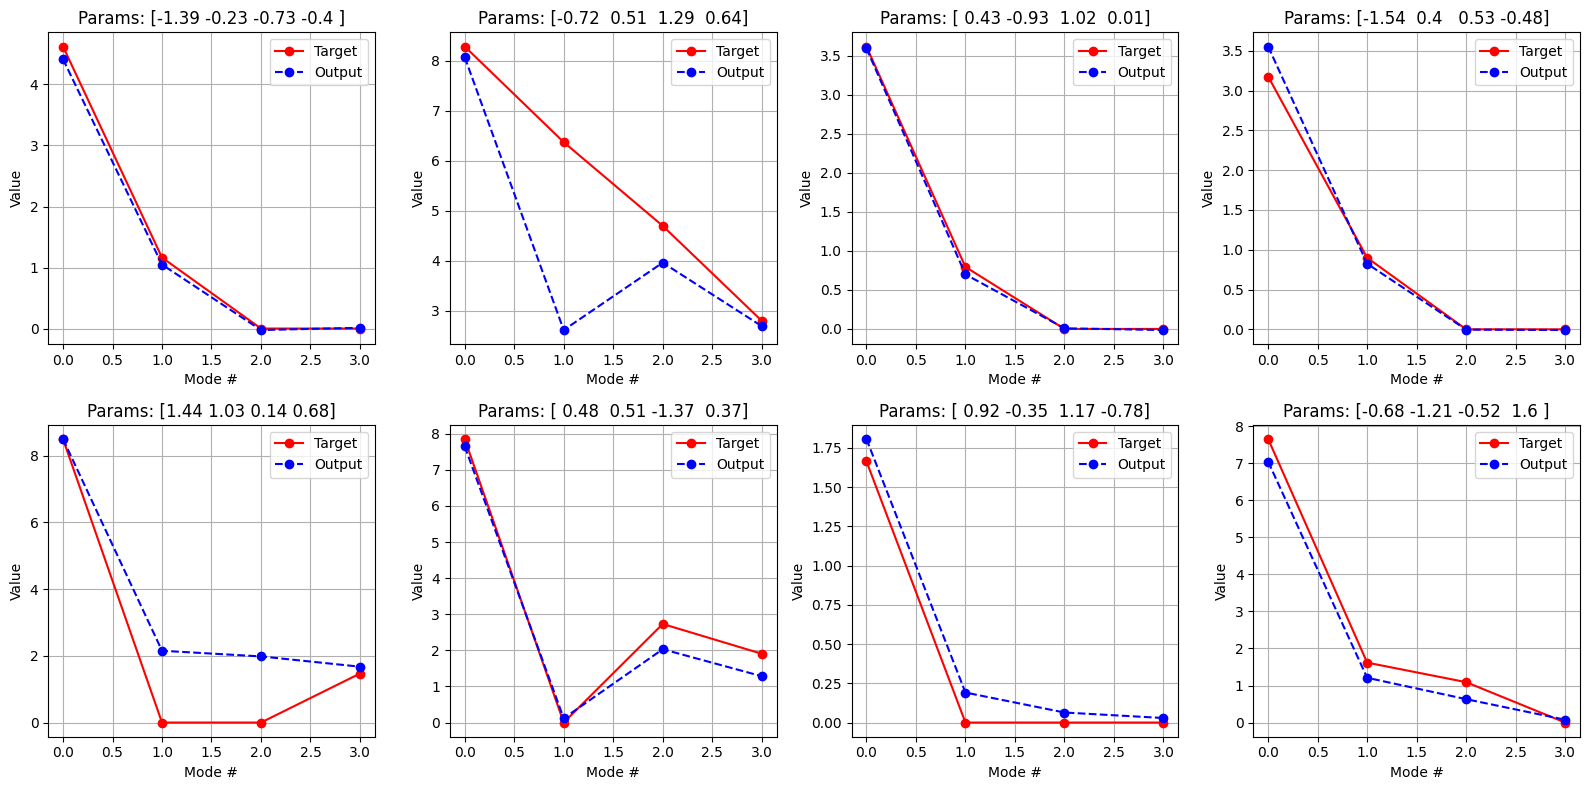

Epoch #15:


100%|██████████| 220/220 [00:26<00:00,  8.15it/s]



Test set: Average loss: 0.1526



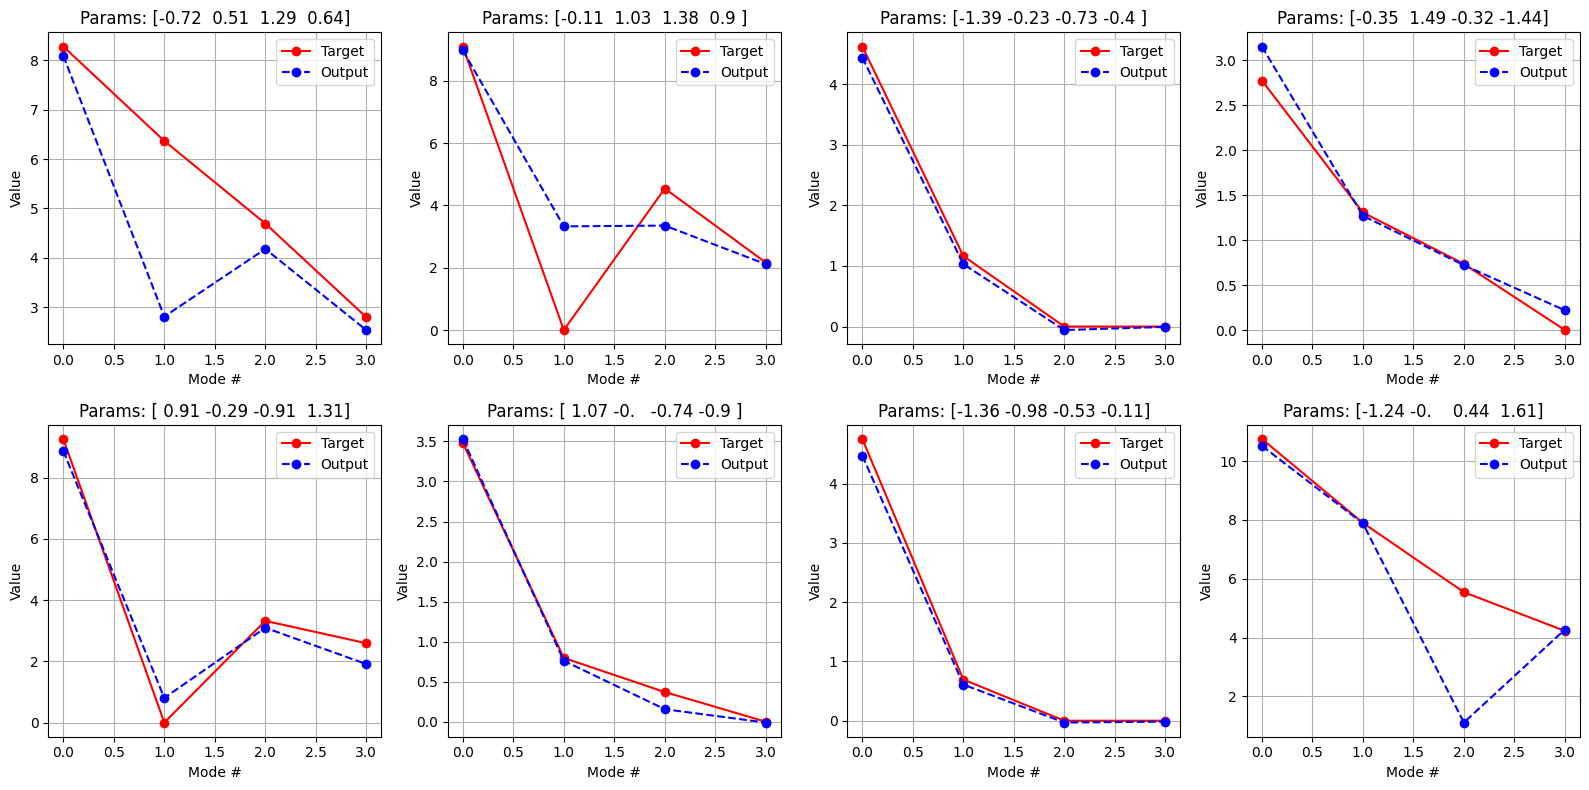

Epoch #16:


100%|██████████| 220/220 [00:25<00:00,  8.47it/s]



Test set: Average loss: 0.1526



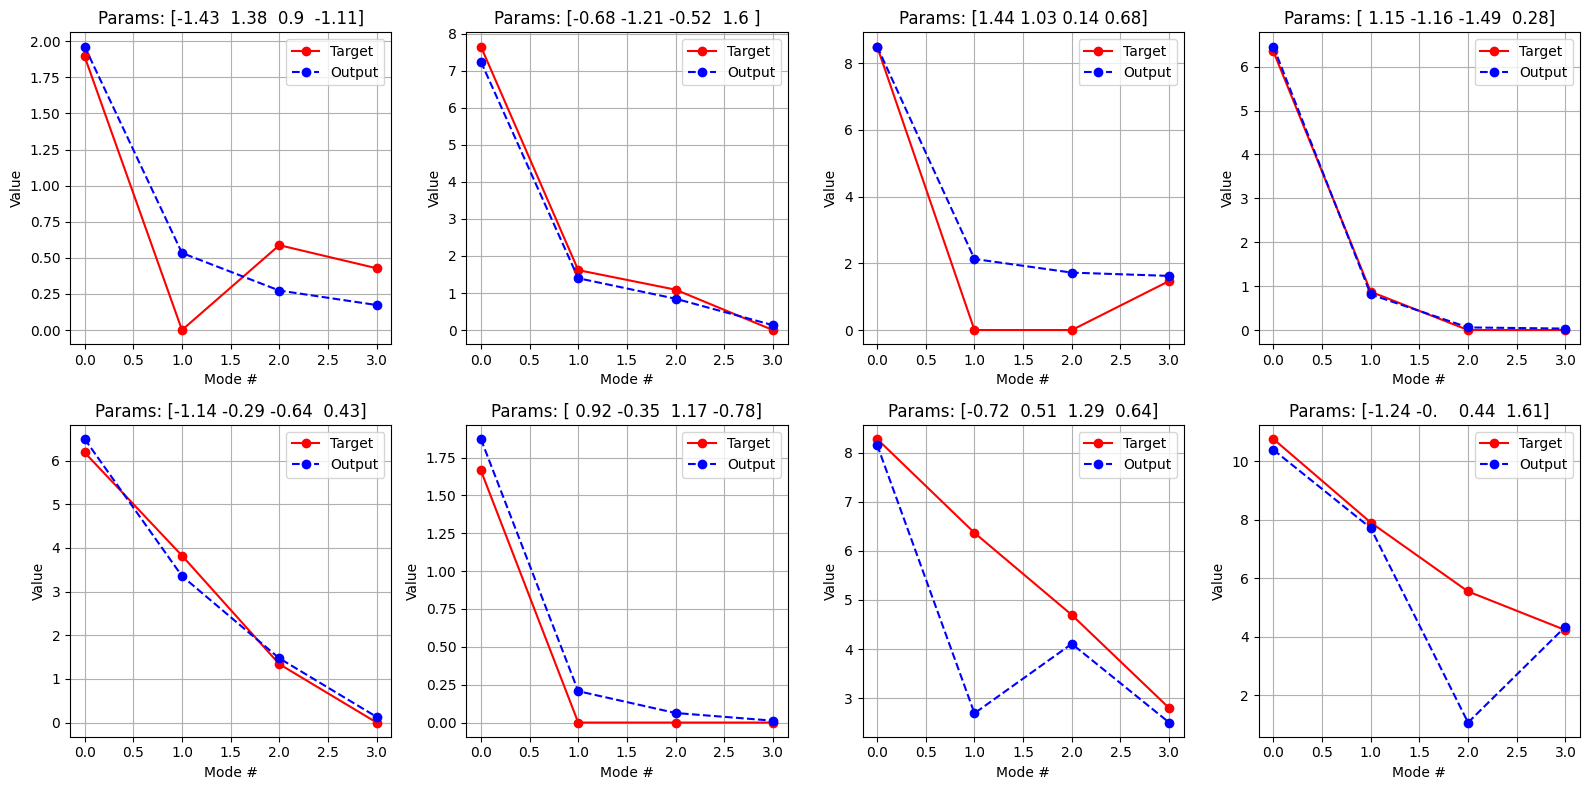

Epoch #17:


100%|██████████| 220/220 [00:25<00:00,  8.72it/s]



Test set: Average loss: 0.1526



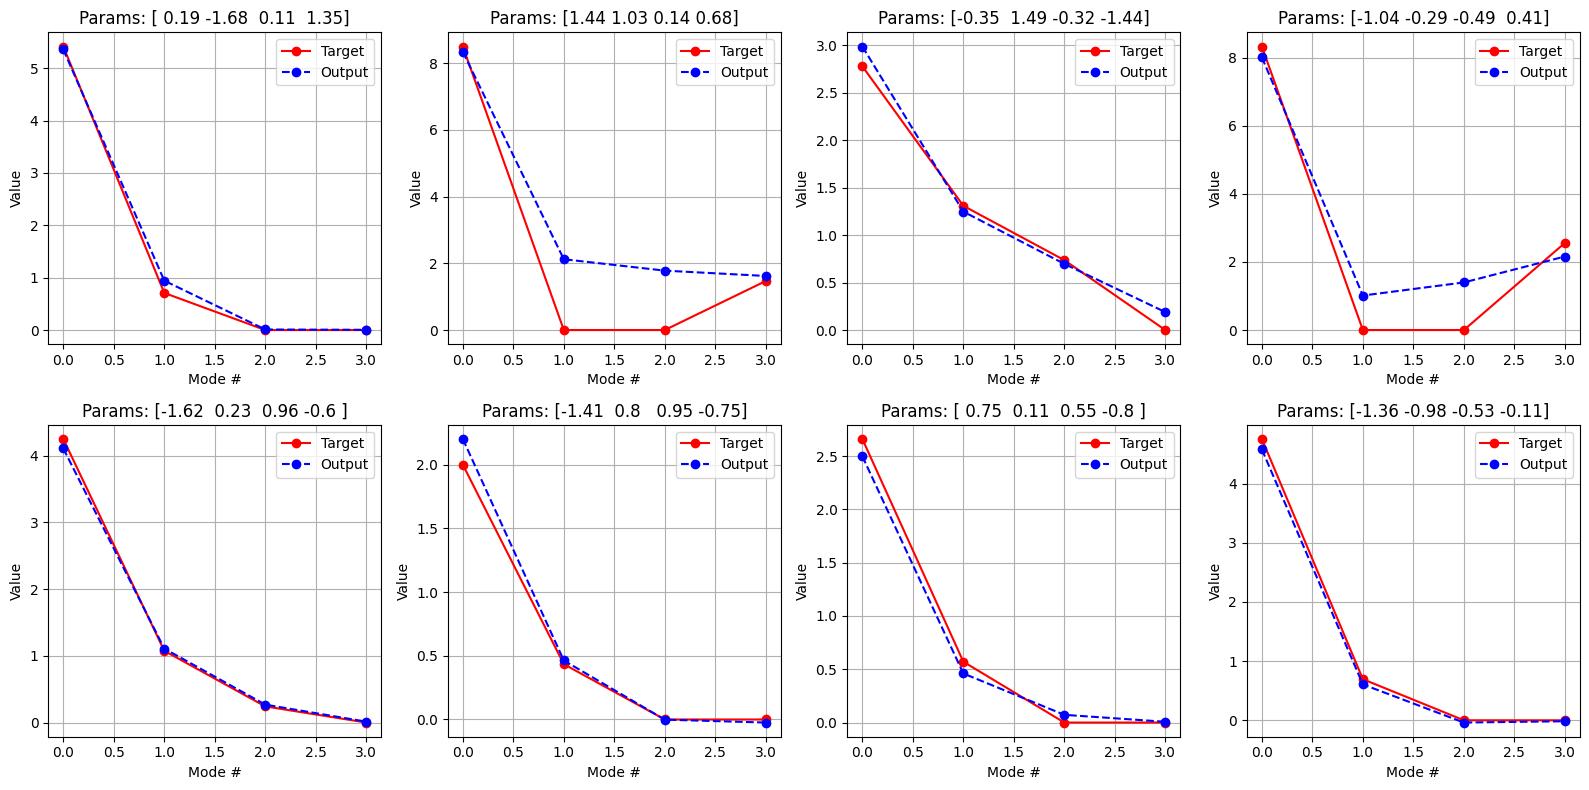

Epoch #18:


100%|██████████| 220/220 [00:25<00:00,  8.69it/s]



Test set: Average loss: 0.1500



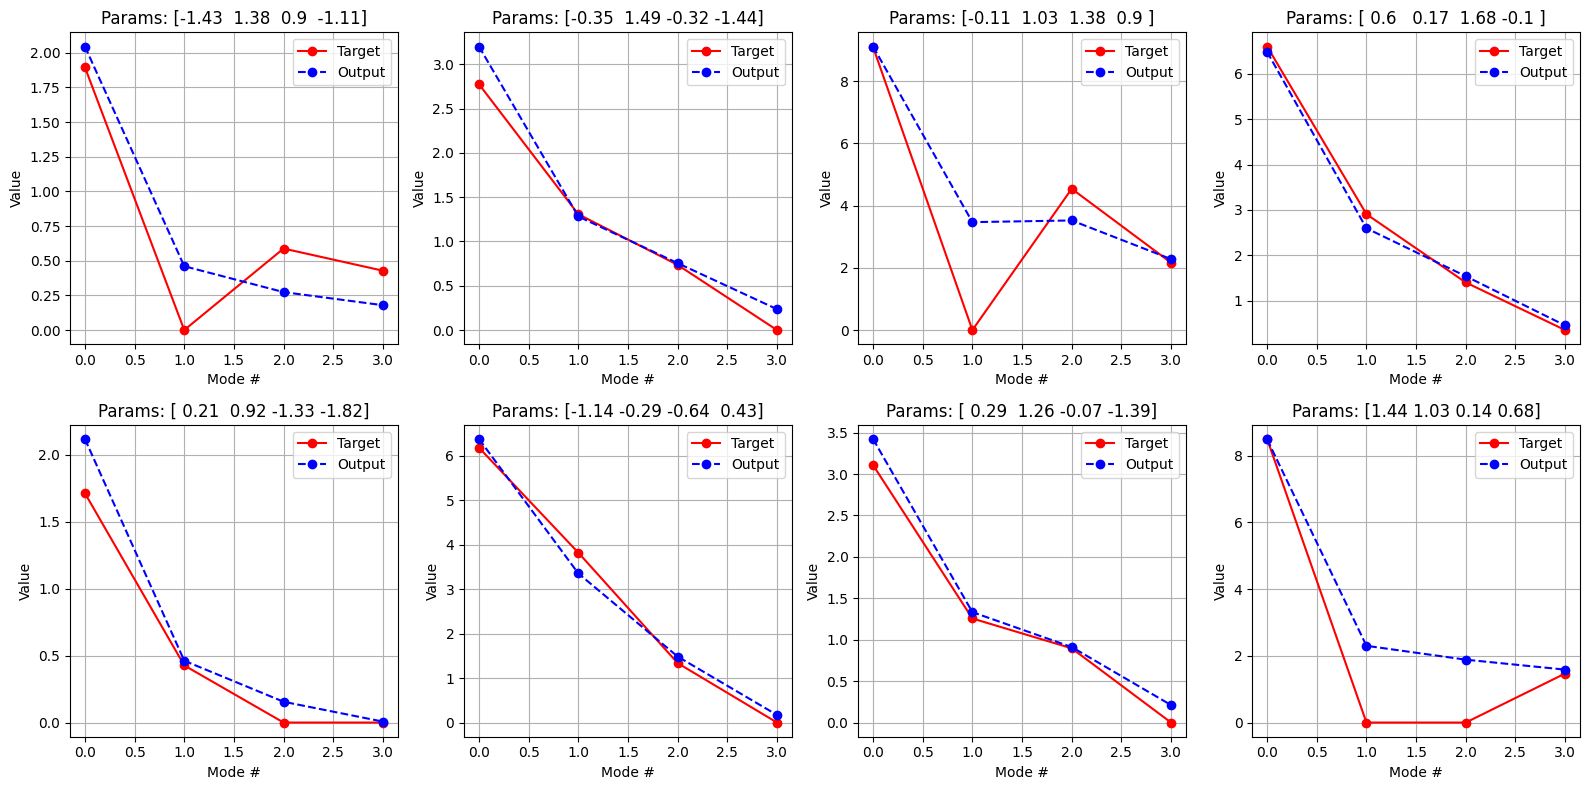

Epoch #19:


100%|██████████| 220/220 [00:25<00:00,  8.63it/s]



Test set: Average loss: 0.1527



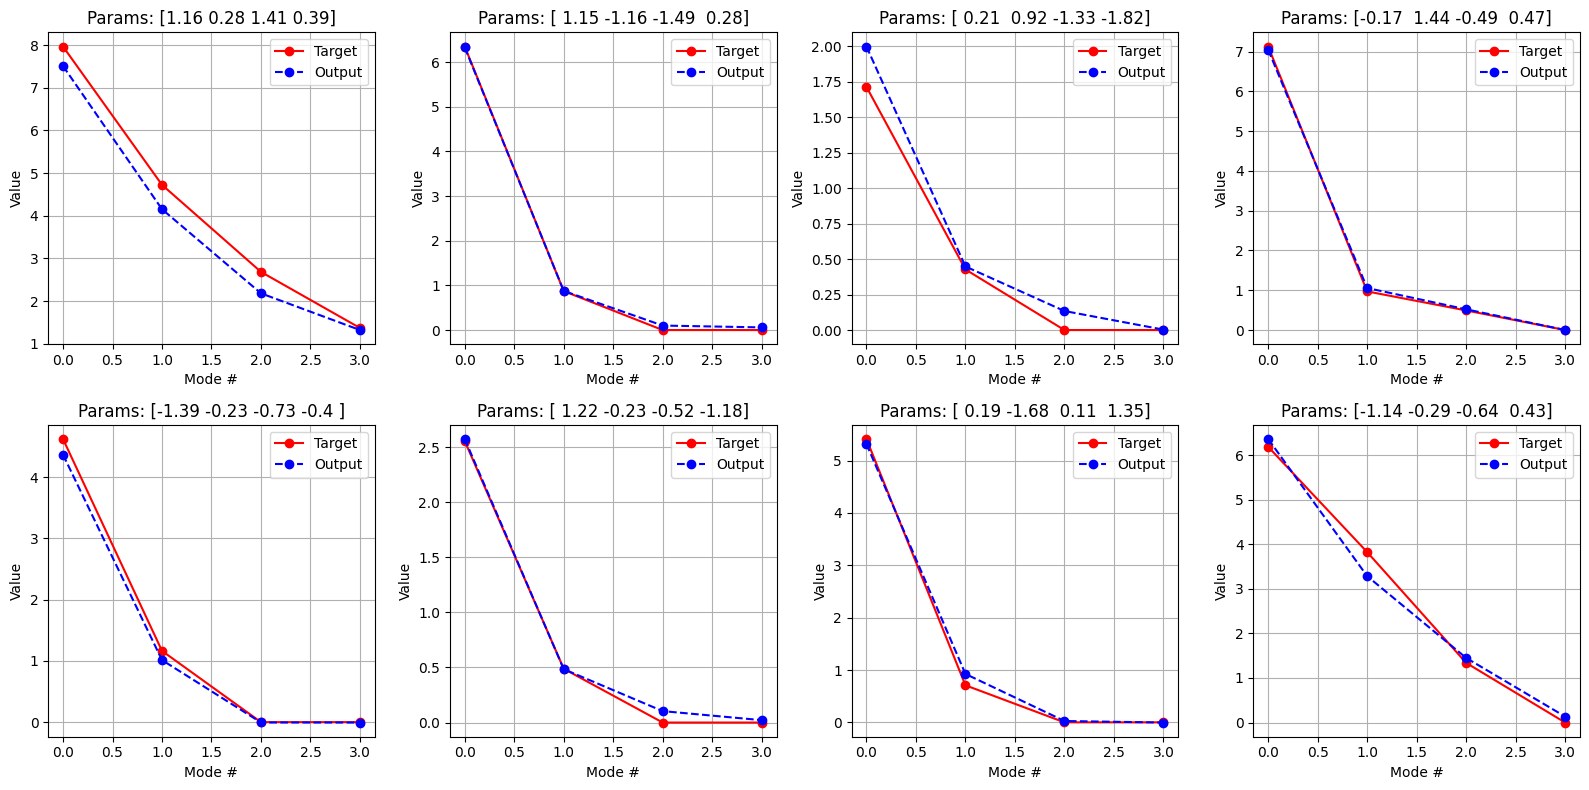

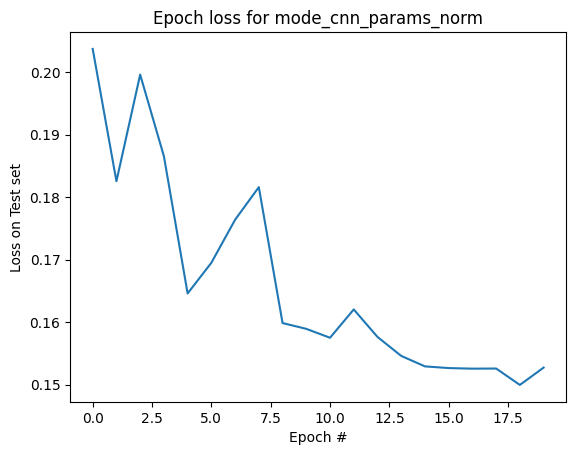

In [8]:
def main(dataset):
    os.makedirs("models", exist_ok=True)
    batch_size = 128
    test_batch_size = 1000
    lr = 2e-3
    gamma = 0.9
    epochs = 20
    save_dir = 'mode_cnn_params_norm'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = Net3().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    loss_fn = nn.MSELoss()

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=4)
    # pbar_train = tqdm(train_loader)
    # pbar_test = tqdm(test_loader)
    e_loss_graph = []
    for epoch in range(epochs):
        print(f'Epoch #{epoch}:')
        train(model, device, train_loader, optimizer, loss_fn)
        e_loss = test(model, device, test_loader, loss_fn, dataset)
        e_loss_graph.append(e_loss)
        scheduler.step()
        torch.save(model.state_dict(), f'models/{save_dir}.pth')
    plt.title(f"Epoch loss for {save_dir}")
    plt.plot(range(epochs), e_loss_graph)
    plt.xlabel('Epoch #')
    plt.ylabel("Loss on Test set")
if __name__ == '__main__':
    main(dataset)


In [12]:
print(tabulate([['Alice', [1,2,3], 'bruh'], ['Bob', [1,3,4], 'sam']], headers=['Name', 'sam', 'bruh'], tablefmt='orgtbl'))

| Name   | sam       | bruh   |
|--------+-----------+--------|
| Alice  | [1, 2, 3] | bruh   |
| Bob    | [1, 3, 4] | sam    |
